# Imports

## Packages

In [376]:
import pandas as pd
import fbprophet
from fbprophet import Prophet
from dateutil.easter import easter
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pylab as plt
import datetime
import seaborn as sns
import glob 
# Load specific forecasting tools
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
import math
from scipy.stats import normaltest
import holidays
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tabulate import tabulate
import mpl_axes_aligner
from matplotlib.dates import DateFormatter, WeekdayLocator,DayLocator, MONDAY

## File Imports

To use this notebook, download the files from https://nswtollroaddata.com under "Data Downloads" for "M1 Eastern Distibutor (ED)." Select the years 2016, 2017, 2018, 2019, 2020 separately and download each of the CSVs separately. Put them all in a folder and DO NOT include this folder name in user_directory.

In [6]:
#get user directory
user_directory = None

In [7]:
# function to get all of the files
def get_all_dataframes(path_to_data_folder):
    # give the path and this function will return all of the dataframes in a sorted list 
    original_data = glob.glob(path_to_data_folder + "/*/*/*csv",recursive=True)
    test_dataframe_list = []
    training_dataframe_list = []
    for item in original_data:
        with open(item) as f:
            df = pd.read_csv(f, parse_dates=[['Date', 'IntervalStart']], 
                             index_col='Date_IntervalStart')
            if "2020" in str(f):
                test_dataframe_list.append(df)
            else:
                training_dataframe_list.append(df)
    return test_dataframe_list, training_dataframe_list

In [8]:
# import files 
if user_directory is not None:    #i.e.: use the directory given
    test_df_list, train_df_list = get_all_dataframes(user_directory)
else:    # point to my directory
    test_df_list, train_df_list = get_all_dataframes("./eastern_distrib")

In [9]:
len(train_df_list)

48

In [10]:
len(test_df_list)

6

In [11]:
train_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2015-12-01,ED,201602,00:14,1,Car,C,N,William Street North-bound exit ramp,-33.875924,151.217253,Ramp Gantry,6
2015-12-01,ED,201602,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,19


In [12]:
test_df_list[0].head(2)

,AssetID,FinancialQtrID,IntervalEnd,Version,VehicleClass,TollPointID,GantryDirection,GantryLocation,GantryGPSLatitude,GantryGPSLongitude,GantryType,TotalVolume
Date_IntervalStart,,,,,,,,,,,,
2019-12-01,ED,202002,00:14,1,Car,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,161
2019-12-01,ED,202002,00:14,1,Truck,AB,N,Woolloomooloo Toll Plaza North-bound,-33.869714,151.218398,Mainline Gantry,2


# Cleaning the Dataframe

In [13]:
# function to clean the dataframe list 
def clean_dfs(dataframe_list):
    clean_dataframe_list = []
    for df in dataframe_list:
        df_C = df[df['TollPointID'] == 'C']
        df_grouped = pd.DataFrame(df_C.groupby('Date_IntervalStart').TotalVolume.sum())
        clean_dataframe_list.append(df_grouped)
    return clean_dataframe_list

In [14]:
# training dataframes
clean_train_df_list = clean_dfs(train_df_list)
# test dataframes
clean_test_df_list = clean_dfs(test_df_list)

In [15]:
clean_train_df_list[0].head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


## Combing the list dataframes into one dataframe 

In [16]:
train_df = pd.concat(clean_train_df_list)
test_df = pd.concat(clean_test_df_list)

In [17]:
train_df.head(2)

,TotalVolume
Date_IntervalStart,
2015-12-01 00:00:00,6
2015-12-01 00:15:00,5


### Making test_df hourly

In [18]:
test_df_hourly = test_df.resample('h').sum()

In [19]:
test_df_hourly.head(2)

,TotalVolume
Date_IntervalStart,
2019-07-01 00:00:00,29
2019-07-01 01:00:00,15


In [20]:
test_df_hourly.reset_index(inplace=True)

In [21]:
test_df_hourly.shape

(4416, 2)

# Making fbprophet Models
stationarity isn't necessary: https://github.com/facebook/prophet/issues/1029

## Putting df in the format it requires

In [22]:
fb_prophet_train_df = train_df.resample('h').sum()

In [23]:
fb_prophet_train_df.shape

(35064, 1)

In [24]:
fb_prophet_train_df.head(2)

,TotalVolume
Date_IntervalStart,
2015-07-01 00:00:00,19
2015-07-01 01:00:00,16


In [25]:
fb_prophet_train_df.reset_index(inplace=True)

In [26]:
fb_prophet_train_df.columns = ['ds', 'y']

In [27]:
fb_prophet_train_df['ds'][1:3]

1   2015-07-01 01:00:00
2   2015-07-01 02:00:00
Name: ds, dtype: datetime64[ns]

In [28]:
type(fb_prophet_train_df['ds'][0])

pandas._libs.tslibs.timestamps.Timestamp

### Baseline Model 

In [29]:
# matching first monday of test to first monday of july in 2018
test_df_hourly['Date_IntervalStart'][0].day

1

In [30]:
july_2018 = fb_prophet_train_df[fb_prophet_train_df['ds'] == ('2018-07-01 00:00:00')]
july_2018['ds'].iloc[0].day

1

In [31]:
test_df_hourly.shape

(4416, 2)

In [32]:
# I will grab the values from 2018-07-01 to 2018-12-31
baseline_y = fb_prophet_train_df['y'][26304:(26304+4416)].values

In [33]:
len(baseline_y)

4416

### First Model

In [34]:
# not sure what type the ds column should be 
## maybe it should be in datetime format, not pandas version of that 
# fb_prophet_train_df['ds'] = fb_prophet_train_df['ds'].values.astype('<M8[D]')

In [35]:
prophetfmodel = Prophet(daily_seasonality=True)

In [36]:
prophetfmodel.fit(fb_prophet_train_df)

In [37]:
one_week = 24 * 4
test_df_length = len(test_df_hourly)

In [38]:
future = prophetfmodel.make_future_dataframe(periods=test_df_length, freq='H')
future.tail(2)

,ds
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [39]:
forecast = prophetfmodel.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)

,ds,yhat,yhat_lower,yhat_upper
39478,2019-12-31 22:00:00,141.488202,-37.681508,316.515617
39479,2019-12-31 23:00:00,99.260786,-79.064368,285.511551


### Model 2

In [40]:
fb_prophet_train_df.head(2)

,ds,y
0,2015-07-01 00:00:00,19
1,2015-07-01 01:00:00,16


In [41]:
prophetfmodel2 = Prophet(daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [42]:
prophetfmodel2.fit(fb_prophet_train_df)

In [43]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future2 = prophetfmodel2.make_future_dataframe(periods=test_df_length, freq='H')
future2.tail(2)

,ds
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [44]:
forecast2 = prophetfmodel2.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)

,ds,yhat,yhat_lower,yhat_upper
39478,2019-12-31 22:00:00,141.488202,-28.982647,319.339948
39479,2019-12-31 23:00:00,99.260786,-81.593955,279.101486


In [45]:
forecast2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01 00:00:00,502.842307,-111.097781,225.339588,502.842307,502.842307,-444.100945,-444.100945,-444.100945,-431.550261,...,6.552663,6.552663,6.552663,-19.103347,-19.103347,-19.103347,0.0,0.0,0.0,58.741362
1,2015-07-01 01:00:00,502.843385,-203.527610,162.384094,502.843385,502.843385,-512.933543,-512.933543,-512.933543,-501.666887,...,7.867643,7.867643,7.867643,-19.134299,-19.134299,-19.134299,0.0,0.0,0.0,-10.090158


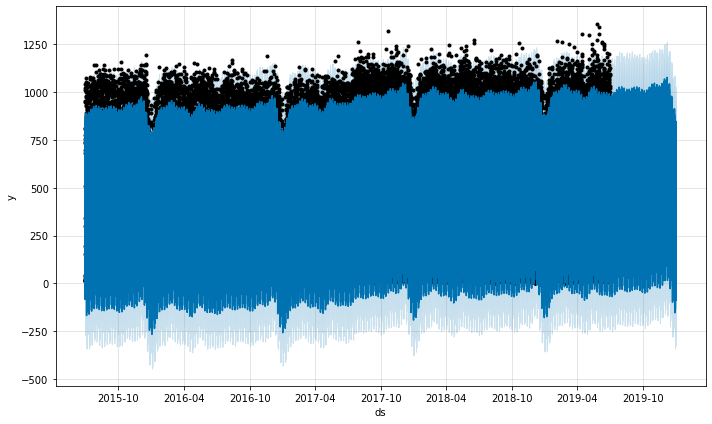

In [46]:
fig2 = prophetfmodel2.plot(forecast2)

#### Plotting Components
https://dius.com.au/2018/09/04/time-series-forecasting-with-fbprophet/

In [47]:
type(forecast2['ds'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [48]:
forecast2.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01 00:00:00,502.842307,-111.097781,225.339588,502.842307,502.842307,-444.100945,-444.100945,-444.100945,-431.550261,...,6.552663,6.552663,6.552663,-19.103347,-19.103347,-19.103347,0.0,0.0,0.0,58.741362
1,2015-07-01 01:00:00,502.843385,-203.527610,162.384094,502.843385,502.843385,-512.933543,-512.933543,-512.933543,-501.666887,...,7.867643,7.867643,7.867643,-19.134299,-19.134299,-19.134299,0.0,0.0,0.0,-10.090158


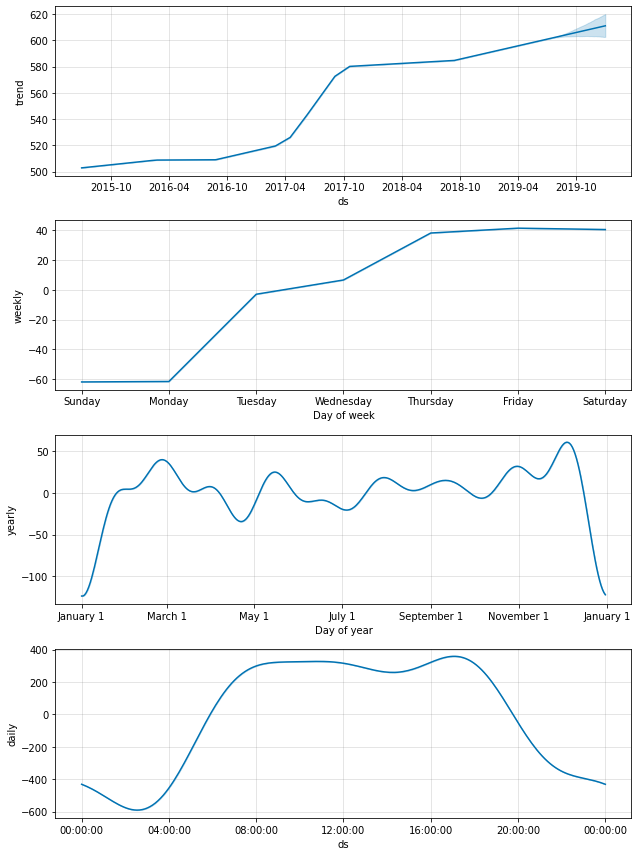

In [49]:
# prints twice unless saved as something
component_fig = prophetfmodel2.plot_components(forecast2)

In [50]:
# https://github.com/facebook/prophet/issues/1304
print(fbprophet.__version__)
print(pd.__version__)

0.5
0.25.3


### Model With Cap and Min
https://facebook.github.io/prophet/docs/saturating_forecasts.html

In [51]:
fb_prophet_train_df['cap'] = 1400
fb_prophet_train_df['floor'] = 0

In [52]:
prophetfmodel3 = Prophet(growth='logistic', daily_seasonality=True, 
                         yearly_seasonality=True, weekly_seasonality=True)

In [53]:
prophetfmodel3.fit(fb_prophet_train_df)

In [54]:
# I can only do hourly or minute frequencies... 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future3 = prophetfmodel3.make_future_dataframe(periods=test_df_length, freq='H')
future3.tail(2)
future3['floor'] = 0
future3['cap'] = 1400

In [55]:
# basically same predictions as before 
forecast3 = prophetfmodel3.predict(future3)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)

,ds,yhat,yhat_lower,yhat_upper
39478,2019-12-31 22:00:00,137.533661,-41.222428,310.114214
39479,2019-12-31 23:00:00,95.305980,-81.376198,294.140731


In [56]:
len(forecast.columns)

22

### Model with Normalization - MinMaxScaler

In [57]:
hourly_values = fb_prophet_train_df['y'].values

In [58]:
hourly_values_reshaped = hourly_values.reshape((len(hourly_values), 1))

In [59]:
hourly_values_reshaped

array([[ 19],
       [ 16],
       [ 11],
       ...,
       [308],
       [253],
       [ 76]])

In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(hourly_values_reshaped)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))

Min: 0.000000, Max: 1359.000000


In [61]:
normalized = scaler.transform(hourly_values_reshaped)
for i in range(5):
    print(normalized[i])

[0.01398087]
[0.01177336]
[0.00809419]
[0.00883002]
[0.02943341]


In [62]:
train_df_days_normalized = fb_prophet_train_df.copy()

In [63]:
train_df_days_normalized['y'] = normalized

In [64]:
train_df_days_normalized.head(2)

,ds,y,cap,floor
0,2015-07-01 00:00:00,0.013981,1400,0
1,2015-07-01 01:00:00,0.011773,1400,0


In [65]:
prophetfmodel4 = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)

In [66]:
prophetfmodel4.fit(train_df_days_normalized)

In [67]:
# I can only do hourly or minute frequencies... 
## https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future4 = prophetfmodel4.make_future_dataframe(periods=test_df_length, freq='H')
future4.tail(2)

,ds
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [68]:
forecast4 = prophetfmodel4.predict(future4)
forecast4[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)

,ds,yhat,yhat_lower,yhat_upper
39478,2019-12-31 22:00:00,0.103524,-0.036721,0.229596
39479,2019-12-31 23:00:00,0.072452,-0.057236,0.205944


In [69]:
# rescaled predictions
orig4_predictions = forecast4['yhat'].values
orig4_predictions_reshaped = orig4_predictions.reshape((len(orig4_predictions), 1))
forecast4_rescaled_predictions = scaler.inverse_transform(orig4_predictions_reshaped)

In [70]:
forecast4_rescaled_predictions.shape

(39480, 1)

In [71]:
forecast4_reshaped = forecast4[-39480:].copy()

In [72]:
forecast4_reshaped.shape

(39480, 22)

In [73]:
forecast4_reshaped['yhat'] = forecast4_rescaled_predictions

In [74]:
# forecast4_reshaped is sliiiiightly different than the other models

### Model with Normalization - QuantileTransformer

In [75]:
scaler2 = QuantileTransformer()
scaler2 = scaler2.fit(hourly_values_reshaped)
print(scaler2.n_quantiles_)

1000


In [76]:
normalized2 = scaler2.transform(hourly_values_reshaped)
for i in range(5):
    print(normalized2[i])

[0.06306306]
[0.04704705]
[0.02352352]
[0.02752753]
[0.14314314]


In [77]:
train_df_days_normalized2 = fb_prophet_train_df.copy()

In [78]:
train_df_days_normalized2['y'] = normalized2

In [79]:
train_df_days_normalized2.head(2)

,ds,y,cap,floor
0,2015-07-01 00:00:00,0.063063,1400,0
1,2015-07-01 01:00:00,0.047047,1400,0


In [80]:
prophetfmodel5 = Prophet(daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True)

In [81]:
prophetfmodel5.fit(train_df_days_normalized2)

In [82]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future5 = prophetfmodel5.make_future_dataframe(periods=test_df_length, freq='H')
future5.tail(2)

,ds
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [83]:
forecast5 = prophetfmodel5.predict(future5)
forecast5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)

,ds,yhat,yhat_lower,yhat_upper
39478,2019-12-31 22:00:00,0.230197,0.080151,0.402826
39479,2019-12-31 23:00:00,0.203061,0.045237,0.356234


In [84]:
# rescaled predictions
orig5_predictions = forecast5['yhat'].values
orig5_predictions_reshaped = orig5_predictions.reshape((len(orig5_predictions), 1))
forecast5_rescaled_predictions = scaler2.inverse_transform(orig5_predictions_reshaped)

In [85]:
forecast5_rescaled_predictions.shape

(39480, 1)

In [86]:
forecast5_reshaped = forecast5[-39480:].copy()

In [87]:
forecast5_reshaped.shape

(39480, 22)

In [88]:
forecast5_reshaped['yhat'] = forecast5_rescaled_predictions

In [89]:
forecast5_reshaped['yhat'].head(2)

0    36.000000
1    16.087564
Name: yhat, dtype: float64

### Standardization

#### Does the data follow a gaussian distribution

In [90]:
# sort data, then plot
sorted_num_of_cars = sorted(hourly_values)

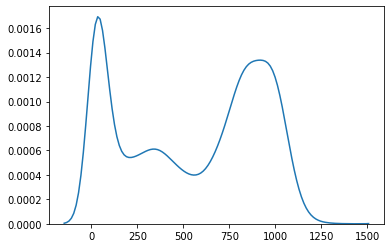

In [91]:
# not really gaussian, so this won't work
sns.kdeplot(sorted_num_of_cars)

#### Testing For Normality

In [92]:
normaltest(sorted_num_of_cars, nan_policy='omit') # not normal

NormaltestResult(statistic=205744.88876666102, pvalue=0.0)

### Power Transform

In [93]:
hourly_values_power_transform = [np.log(x) for x in hourly_values]

In [94]:
sorted_num_of_cars_power_transform = sorted(hourly_values_power_transform)

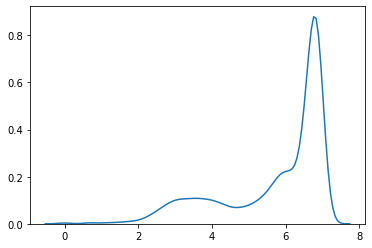

In [95]:
sns.kdeplot(sorted_num_of_cars_power_transform)

In [96]:
# since the p-value is very small, probably not from a normal distribution
## https://stackoverflow.com/questions/12838993/scipy-normaltest-how-is-it-used
normaltest(sorted_num_of_cars_power_transform, nan_policy='omit')  # not normal

NormaltestResult(statistic=nan, pvalue=nan)

### Adding Holidays to Linear Model

#### Getting aussie holidays

In [97]:
aus_holidays = holidays.CountryHoliday('AU', prov='NSW', years = [2015, 2016, 2017, 2018, 2019, 2020])

In [98]:
type(aus_holidays)

holidays.AU

In [99]:
# for date, name in sorted(aus_holidays.items()):
#     print(date, name)

In [100]:
datetime.date(2015, 1, 1) in aus_holidays

True

In [101]:
# making into a df
aus_holidays_df = pd.DataFrame.from_dict(aus_holidays, orient='index').reset_index()

In [102]:
aus_holidays_df.columns = ['ds', 'holiday']

In [103]:
aus_holidays_df['lower_window'] = -1
aus_holidays_df['upper_window'] = 1

In [104]:
# fbprophet's example 
playoffs = pd.DataFrame({
  'holiday': 'playoff',
  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                        '2010-01-24', '2010-02-07', '2011-01-08',
                        '2013-01-12', '2014-01-12', '2014-01-19',
                        '2014-02-02', '2015-01-11', '2016-01-17',
                        '2016-01-24', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
superbowls = pd.DataFrame({
  'holiday': 'superbowl',
  'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
  'lower_window': 0,
  'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))

In [105]:
holidays.head(2)

,holiday,ds,lower_window,upper_window
0,playoff,2008-01-13,0,1
1,playoff,2009-01-03,0,1


#### Model 6

In [106]:
prophetfmodel6 = Prophet(daily_seasonality=True, yearly_seasonality = True, weekly_seasonality = True, 
                         holidays=aus_holidays_df)

In [107]:
prophetfmodel6.fit(fb_prophet_train_df)

In [108]:
six_month = (24 * 7)
test_df_length = len(test_df_hourly)

In [109]:
# I can only do hourly or minute frequencies... 
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future6 = prophetfmodel6.make_future_dataframe(periods=test_df_length, freq='H')
future6.tail()

,ds
39475,2019-12-31 19:00:00
39476,2019-12-31 20:00:00
39477,2019-12-31 21:00:00
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [110]:
forecast6 = prophetfmodel6.predict(future6)
forecast6[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,677.892929,498.248856,857.696418
39476,2019-12-31 20:00:00,464.442972,294.429156,630.186276
39477,2019-12-31 21:00:00,274.673677,111.670727,448.114850
39478,2019-12-31 22:00:00,165.514624,-17.446234,341.288224
39479,2019-12-31 23:00:00,123.025359,-57.425855,292.157421


In [111]:
forecast6.head(2)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Anzac Day,Anzac Day_lower,Anzac Day_upper,Australia Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-07-01 00:00:00,509.357045,-119.868430,228.464813,509.357045,509.357045,0.0,0.0,0.0,0.0,...,4.210386,4.210386,4.210386,-26.361988,-26.361988,-26.361988,0.0,0.0,0.0,55.656750
1,2015-07-01 01:00:00,509.358393,-192.300053,161.061344,509.358393,509.358393,0.0,0.0,0.0,0.0,...,5.357728,5.357728,5.357728,-26.414452,-26.414452,-26.414452,0.0,0.0,0.0,-13.361854


#### Plotting components

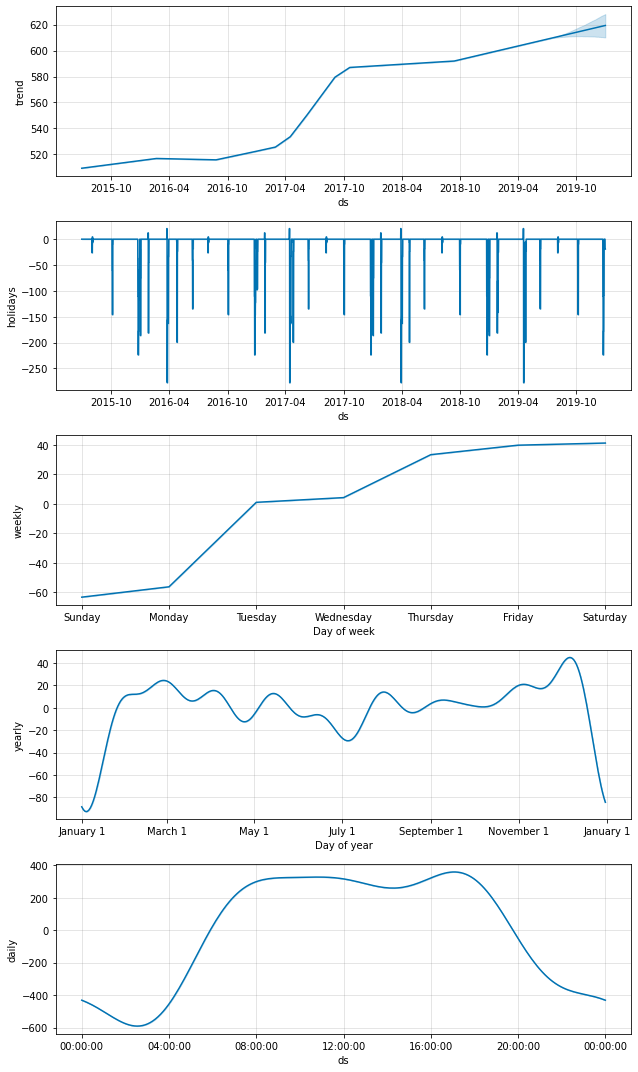

In [112]:
component_fig2 = prophetfmodel6.plot_components(forecast6)

### Logistic model with holidays

In [113]:
prophetfmodel7 = Prophet(growth='logistic', daily_seasonality=True, yearly_seasonality = True, 
                         weekly_seasonality = True, holidays=aus_holidays_df)

In [114]:
prophetfmodel7.fit(fb_prophet_train_df)

In [115]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future7 = prophetfmodel7.make_future_dataframe(periods=test_df_length, freq='H')
future7.tail(2)
future7['floor'] = 0
future7['cap'] = 1400

In [116]:
# basically same predictions as before 
forecast7 = prophetfmodel7.predict(future7)
forecast7[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
39475,2019-12-31 19:00:00,672.524763,494.398461,842.195690
39476,2019-12-31 20:00:00,459.073091,283.685352,639.708434
39477,2019-12-31 21:00:00,269.302299,94.952877,446.888593
39478,2019-12-31 22:00:00,160.142154,-20.544184,320.987655
39479,2019-12-31 23:00:00,117.652169,-66.086188,277.937879


In [117]:
len(forecast.columns)

22

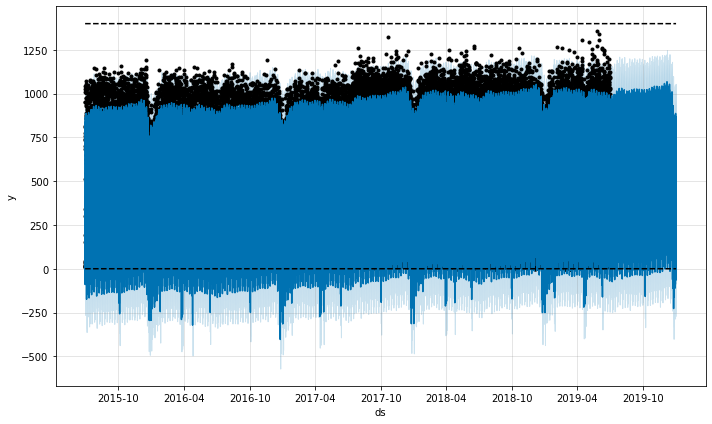

In [118]:
fig7 = prophetfmodel7.plot(forecast7)

### Normalization and Holidays Model

In [119]:
prophetfmodel8 = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True,
                        holidays=aus_holidays_df)

In [120]:
prophetfmodel8.fit(train_df_days_normalized)

In [121]:
# I can only do hourly or minute frequencies... https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
## Either I change the data to be hourly or I try minutes
future8 = prophetfmodel8.make_future_dataframe(periods=test_df_length, freq='H')
future8.tail(2)

,ds
39478,2019-12-31 22:00:00
39479,2019-12-31 23:00:00


In [122]:
forecast8 = prophetfmodel8.predict(future8)
forecast8[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(2)

,ds,yhat,yhat_lower,yhat_upper
39478,2019-12-31 22:00:00,0.122535,-0.003711,0.262443
39479,2019-12-31 23:00:00,0.091271,-0.027534,0.226744


In [123]:
# rescaled predictions
orig8_predictions = forecast8['yhat'].values
orig8_predictions_reshaped = orig8_predictions.reshape((len(orig8_predictions), 1))
forecast8_rescaled_predictions = scaler.inverse_transform(orig8_predictions_reshaped)

In [124]:
forecast8_rescaled_predictions.shape

(39480, 1)

In [125]:
forecast8_reshaped = forecast8[-39480:].copy()

In [126]:
forecast8_reshaped.shape

(39480, 73)

In [127]:
forecast8_reshaped['yhat'] = forecast8_rescaled_predictions

# LSTM Model

## Transform Data

In [128]:
def add_features_for_LSTM(df):
    df['month']=[i.month for i in df['Date_IntervalStart']]
    df['day']=[i.day for i in df['Date_IntervalStart']]
    df["hour"]=[i.hour for i in df['Date_IntervalStart']]
    df['target']=df['TotalVolume']
    df=df.drop(columns=['TotalVolume','Date_IntervalStart'])
    return df

In [129]:
test_df_LSTM = add_features_for_LSTM(test_df_hourly)

In [130]:
train_df.reset_index(inplace=True)
train_df_LSTM = add_features_for_LSTM(train_df)
# train_df_LSTM.drop(columns = ['index'])

In [131]:
train_df_LSTM.head(2)

,month,day,hour,target
0,12,1,0,6
1,12,1,0,5


## Reshape Data

In [132]:
# Code Source: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# create the reshape function
def reshape_data(train,test):
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

In [133]:
# using the function to obtain reshaped x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=reshape_data(train_df_LSTM,test_df_LSTM)

## Running Model

In [134]:
# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(x_train, y_train, epochs=25, batch_size=50, verbose=1, shuffle=False)

Epoch 1/25
138840/138840 [==============================] - 6s 42us/step - loss: 849.3974
Epoch 2/25
138840/138840 [==============================] - 6s 42us/step - loss: 456.0647
Epoch 3/25
138840/138840 [==============================] - 6s 43us/step - loss: 454.1387
Epoch 4/25
138840/138840 [==============================] - 6s 43us/step - loss: 450.9413
Epoch 5/25
138840/138840 [==============================] - 6s 44us/step - loss: 451.0110
Epoch 6/25
138840/138840 [==============================] - 6s 42us/step - loss: 451.6442
Epoch 7/25
138840/138840 [==============================] - 5s 39us/step - loss: 451.8782
Epoch 8/25
138840/138840 [==============================] - 6s 40us/step - loss: 448.4256
Epoch 9/25
138840/138840 [==============================] - 6s 41us/step - loss: 449.4519
Epoch 10/25
138840/138840 [==============================] - 6s 43us/step - loss: 447.6347
Epoch 11/25
138840/138840 [==============================] - 6s 40us/step - loss: 445.8949
Epoch 12

### Visualize loss function

In [135]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss'])

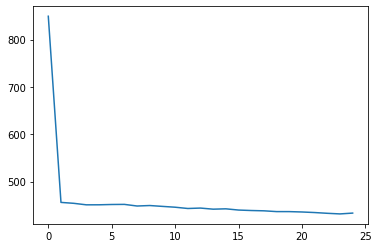

In [136]:
# Plot the loss vs the number of epoch
sns.lineplot(x = range(len(history_dict['loss'])), y=history_dict['loss'])

In [137]:
# make a prediction
y_test_pre=model.predict(x_test)

In [138]:
y_test_pre_flattened = y_test_pre.flatten()

In [139]:
print(y_test_pre.shape)
print(y_test_pre_flattened.shape)

(4415, 1)
(4415,)


# Evaluating Models

## Data

### No neg values for some models

In [140]:
def no_neg(data):
    data_series = data[['yhat']]
    data_series['yhat'] = [0 if x < 0 else x for x in data_series['yhat']]
    return data_series

In [141]:
forecast8_no_negs = no_neg(forecast8_reshaped)

In [142]:
forecast5_no_negs = no_neg(forecast5_reshaped)

In [143]:
forecast2_no_negs = no_neg(forecast2)

In [144]:
forecast3_no_negs = no_neg(forecast3)

In [156]:
# LSTM_no_negs = no_neg(y_test_pre_flattened)
# https://stackoverflow.com/questions/19766757/replacing-numpy-elements-if-condition-is-met/19767068
y_test_pre_flattened_no_negs = np.copy(y_test_pre_flattened)
y_test_pre_flattened_no_negs[y_test_pre_flattened_no_negs<0] = 0

In [185]:
# verifying there are no negatives in y_test_pre_flattened_no_negs
for item in y_test_pre_flattened_no_negs:
    if item < 0:
        print(item)

### All Data

In [157]:
# these models do WAAAY better over the long term
labels = ['Model1_15mins', 'Model2_lin', 'Model3_log', 'Model4_norm', 'Model5_norm2', 'Model6_lin_holidays',
         "Model7_log_holidays", "Model8_norm_holidays", "Baseline", "Model8_no_negs", "Model5_no_negs",
         "Model2_no_negs", "Model3_no_negs", "LSTM_Model", "LSTM_Model_no_negs"]
preds_list = [forecast[['yhat']][35087:], 
             forecast2[['yhat']][-test_df_length:-23],
             forecast3[['yhat']][-test_df_length:-23],
             forecast4_reshaped[['yhat']][-test_df_length:-23],
             forecast5_reshaped[['yhat']][-test_df_length:-23],
             forecast6[['yhat']][-test_df_length:-23],
             forecast7[['yhat']][-test_df_length:-23],
             forecast8_reshaped[['yhat']][-test_df_length:-23],
             baseline_y[-test_df_length:-23],
             forecast8_no_negs[['yhat']][-test_df_length:-23],
             forecast5_no_negs[['yhat']][-test_df_length:-23],
             forecast2_no_negs[['yhat']][-test_df_length:-23],
             forecast3_no_negs[['yhat']][-test_df_length:-23],
             y_test_pre_flattened[:-22], # note that LSTM model isn't consistent at this number, it varies based on random inputs 
             y_test_pre_flattened_no_negs[:-22]]

## Functions to calculate metrics and return results as df

In [158]:
# https://medium.com/@joydeepubuntu/common-metrics-for-time-series-analysis-f3ca4b29fe42
# https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
def evaluate_models(model_name_list, predictions, test_df):
    test_df_length = test_df.shape[0]
    true_values = test_df['TotalVolume'].iloc[-test_df_length:-23].values
    return_df = pd.DataFrame(index = model_name_list)
    metric_list = []
    for i in range(len(predictions)):
        mse = mean_squared_error(true_values, predictions[i])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(true_values, predictions[i])
        Medae = median_absolute_error(true_values, predictions[i])
        # High R² means that the correlation between observed and predicted values is high
        r2 = r2_score(true_values, predictions[i])
        # https://machinelearningmastery.com/time-series-forecasting-performance-measures-with-python/
#         prediction_reset_index = predictions[i].reset_index(drop=True)
        if type(predictions[i]) == pd.core.frame.DataFrame:
            mfe = [true_values[x]-predictions[i]['yhat'].iloc[x] for x in range(len(predictions[i]))]
        elif type(predictions[i]) == np.ndarray:
            mfe = list(true_values-predictions[i])
        mfe_bias = (sum(mfe) * 1.0)/len(predictions[i])
        metric_list.append([mse, rmse, mae, Medae, r2, mfe_bias])
    return_df['MSE'] = [round(x[0], 2) for x in metric_list]
    return_df['RMSE'] = [round(x[1],2) for x in metric_list]
    return_df['MAE'] = [round(x[2],2) for x in metric_list]
    return_df['MedAE'] = [round(x[3],2) for x in metric_list]
    return_df['R2_score'] = [round(x[4], 2) for x in metric_list]
    return_df['MFE_Bias'] = [round(x[5], 2) for x in metric_list]
    return return_df

## Evaluating Models

In [159]:
model_metrics_df = evaluate_models(labels, preds_list, test_df_hourly)

In [160]:
# low medAE for baseline b/c no negative guesses
model_metrics_df

,MSE,RMSE,MAE,MedAE,R2_score,MFE_Bias
Model1_15mins,39867.83,199.67,148.11,113.28,0.76,2.95
Model2_lin,22882.04,151.27,112.16,83.19,0.86,2.62
Model3_log,22903.97,151.34,112.25,83.66,0.86,4.07
Model4_norm,22887.43,151.29,112.17,83.42,0.86,3.24
Model5_norm2,24298.85,155.88,111.53,82.00,0.85,-11.65
Model6_lin_holidays,22288.62,149.29,111.22,84.19,0.86,1.80
Model7_log_holidays,22318.67,149.39,111.28,84.84,0.86,4.55
Model8_norm_holidays,22284.56,149.28,111.22,84.09,0.86,1.07
Baseline,28281.38,168.17,103.02,63.00,0.83,26.76
Model8_no_negs,22096.00,148.65,110.18,81.77,0.87,0.04


### Saving df

In [184]:
# model_metrics_df.to_csv("./saved_data/Model_summary_df.csv")

### Saving df to markdown

In [180]:
# https://gist.github.com/jplsightm/c7df5cd2bc62dc84c5158a80cf0af6df
def pandas_df_to_markdown_table(df):
    # Dependent upon ipython
    # shamelessly stolen from https://stackoverflow.com/questions/33181846/programmatically-convert-pandas-dataframe-to-markdown-table
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    #display(Markdown(df_formatted.to_csv(sep="|", index=False)))
    return Markdown(df_formatted.to_csv(sep="|", index=False))

In [176]:
model_metrics_df_w_index = model_metrics_df.reset_index()

In [177]:
model_metrics_df_md = pandas_df_to_markdown_table(model_metrics_df_w_index)

### Picking best values for each row

In [162]:
# LSTM is best in 4 of the 6 categories
for col in model_metrics_df.columns:
    if col in ['MAE', "MedAE", 'MSE', 'RMSE']: # min cols 
        min_col = model_metrics_df[col].min()
        min_col_model = model_metrics_df.index[list(model_metrics_df[col]).index(min_col)]
        print(f"The min for {col} is {min_col_model}")
    elif col in ['R2_score']: # max cols
        max_col = model_metrics_df[col].max()
        max_col_model = model_metrics_df.index[list(model_metrics_df[col]).index(max_col)]
        print(f"The max for {col} is {max_col_model}")
    elif col in ['MFE_Bias']:
        low_abs = min(model_metrics_df.MFE_Bias, key=abs)
        low_abs_col = model_metrics_df.index[list(model_metrics_df[col]).index(low_abs)]
        print(f"The lowest absolute value for {col} is {low_abs_col}")

The min for MSE is LSTM_Model
The min for RMSE is LSTM_Model
The min for MAE is LSTM_Model
The min for MedAE is LSTM_Model
The max for R2_score is LSTM_Model
The lowest absolute value for MFE_Bias is Model8_no_negs


### Visualize the best performing models

In [163]:
# until 12-31-2019 midnight
test_df_model_comparisons = test_df_hourly[:-23].copy()

In [259]:
test_df_model_comparisons['LSTM'] = y_test_pre_flattened[:-22]
test_df_model_comparisons['Baseline'] =  baseline_y[-test_df_length:-23]
test_df_model_comparisons['Model8_no_negs'] = forecast8_no_negs[['yhat']][-test_df_length:-23].values
test_df_model_comparisons['Model5_no_negs'] = forecast5_no_negs[['yhat']][-test_df_length:-23].values

In [260]:
test_df_model_comparisons.head(2)

,Date_IntervalStart,TotalVolume,month,day,hour,target,LSTM,Baseline,Model8_no_negs,Model5_no_negs
0,2019-07-01 00:00:00,29,7,1,0,29,26.097706,148,94.998608,50.601437
1,2019-07-01 01:00:00,15,7,1,1,15,9.563038,74,28.402235,24.000000


In [269]:
small_test_df_model_comparisons = test_df_model_comparisons[4200:]

#### Adding day of week column to df

In [270]:
small_test_df_model_comparisons['dayofweek'] = [x.day_name() for x in small_test_df_model_comparisons['Date_IntervalStart']]

In [271]:
dayofweek_dict = {}

In [272]:
small_test_df_model_comparisons.head()

,Date_IntervalStart,TotalVolume,month,day,hour,target,LSTM,Baseline,Model8_no_negs,Model5_no_negs,dayofweek
4200,2019-12-23 00:00:00,76,12,23,0,76,59.721535,168,101.062374,40.097625,Monday
4201,2019-12-23 01:00:00,47,12,23,1,47,41.973534,92,34.195705,19.000000,Monday
4202,2019-12-23 02:00:00,30,12,23,2,30,24.748772,49,0.000000,0.000000,Monday
4203,2019-12-23 03:00:00,22,12,23,3,22,21.433290,27,0.000000,2.719645,Monday
4204,2019-12-23 04:00:00,62,12,23,4,62,71.382393,49,90.946767,35.000000,Monday


In [273]:
small_test_df_model_comparisons.day.nunique()

9

In [274]:
daysofweek_for_graph = list(small_test_df_model_comparisons.dayofweek.unique())

In [275]:
daysofweek_for_graph.extend(['Monday', 'Tuesday'])

In [276]:
len(daysofweek_for_graph)

9

In [332]:
# add weekday names to date
fig = plt.figure(figsize=(20,4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(small_test_df_model_comparisons.Date_IntervalStart,small_test_df_model_comparisons.LSTM,label='LSTM')
ax1.plot(small_test_df_model_comparisons.Date_IntervalStart,small_test_df_model_comparisons.Baseline,label='Baseline')
ax1.plot(small_test_df_model_comparisons.Date_IntervalStart,small_test_df_model_comparisons.Model8_no_negs,label='Model8_no_negs')
ax1.plot(small_test_df_model_comparisons.Date_IntervalStart,small_test_df_model_comparisons['TotalVolume'],label='Actual Values', linewidth=3.5)
# ax2.plot(small_test_df_model_comparisons.Date_IntervalStart,small_test_df_model_comparisons.Model5_no_negs,label='Model5_no_negs')
xlims = ax1.get_xlim()
locs = ax1.get_xticks()
locs2, labels = plt.xticks()
# ax2.set_xticks(locs)
ax1.set_xlim(0.0, 1.0)
ax2.set_xlim(0.0, 1.0)
mpl_axes_aligner.align.xaxes(ax1, 0, ax2, 0.3)
# ax2.set_xticks(np.linspace(ax1.get_xticks()[0], ax1.get_xticks()[-1], len(ax1.get_xticks())))
# ax2.xaxis.set_major_locator(matplotlib.ticker.LinearLocator(10))
# ax2.set_xticks(x_tick_marks[::-1]) # close but not quite 
# ax2.set_xticklabels(daysofweek_for_graph)
plt.title('Prediction VS Actual Values for Test Data',fontsize=20)
ax1.legend(loc='bottom left')
plt.show()

AttributeError: module 'mpl_axes_aligner' has no attribute 'align'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7ff682b932f0> (for post_execute):


ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum 0.0 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [364]:
locs

array([737416., 737417., 737418., 737419., 737420., 737421., 737422.,
       737423., 737424.])

Text(0.5, 1.0, 'Comparison of Model Performance')

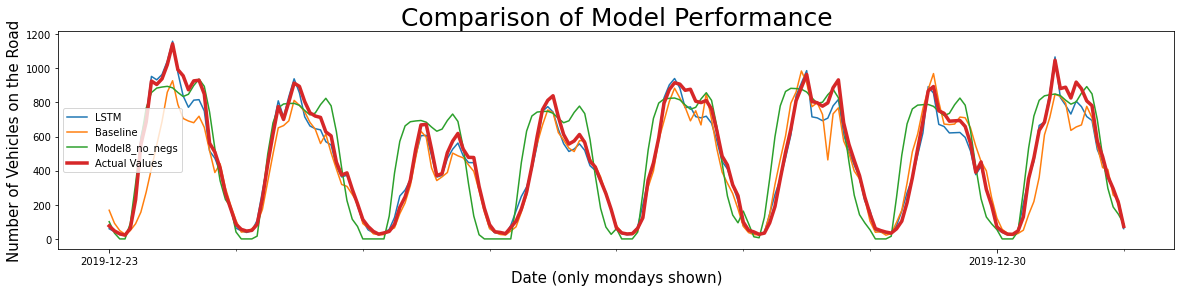

In [411]:
# seaborn attempt
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(111)
mondays = matplotlib.dates.WeekdayLocator(MONDAY) 
alldays = DayLocator()
sns.lineplot(x = 'Date_IntervalStart', y = 'LSTM', data=small_test_df_model_comparisons, 
            label = 'LSTM'),
sns.lineplot(x = 'Date_IntervalStart', y = 'Baseline', data=small_test_df_model_comparisons, 
             label = 'Baseline'),
sns.lineplot(x = 'Date_IntervalStart', y = 'Model8_no_negs', data=small_test_df_model_comparisons,
            label ='Model8_no_negs'),
sns.lineplot(x = 'Date_IntervalStart', y = 'TotalVolume', linewidth=3.5, data=small_test_df_model_comparisons,
            label = 'Actual Values')
ax.xaxis.set_major_locator(mondays)
ax.xaxis.set_minor_locator(alldays)
# ax.set(xlabel='Date (only mondays shown)', ylabel='Number of Cars on Road', fontsize= 20)
plt.xlabel('Date (only mondays shown)', fontsize = 15)
plt.ylabel('Number of Vehicles on the Road', fontsize = 15)
plt.title("Comparison of Model Performance", fontsize = 25)

### Saving Image

In [412]:
fig.savefig("Comparison_of_model_performance") 

# Conclusions 

- This project aimed to model the traffic patterns on the Eastern Distributor Highway (M1) in Sydney, Australia. This effort would benefit any business that uses this highway regularly, and the Australian Government in controlling the influx of cars leading into Sydney from the south. Additionally, people in the southern suburbs can use this data to plan their trips to avoid as much traffic as possible, both on a daily and weekly time scale. 
- The models are varied in their predictions but there are clear winners depending on the type of prediction required:
    - LSTM Model: The overall winner for predictions. If one is looking to know how many cars are on the road over a substantial period of time, this model is the most accurate (individual guess will vary, especially as an undercount of the true number of cars)
    - Model 8 (no lag): This model is best for guessing in equal proportion above and below the true number of cars on the road. This will be helpful for businesses that are equally biased in guesses. This makes the model more stable than the other ones created.